# Saliency Methods

## How it works
Saliency methods aim to infer insights about the function f(x) learnt by the model by ranking the inputs by their explanatory power. It describes the marginal effect of a feature to the output with respect to the same input where such feature has been removed. Note that saliency methods must take the input into account when computing attributions, which is different from Activation Maximization method. 

It is important to note that although we are interested to find out the marginal effect of a feature, there is no proper way to remove features as most neural network models require a fixed number of features. Therefore, the actual implementation is often achieved by simulating the absence of a feature. By choosing a baseline $\bar{x}$, which can represent the absence of information, we can then compute attributions with respect to the baseline. Common ways to construct $\bar{x}$ includes adding a constant value, injecting noise and blurring the image. 

## Types of Saliency Methods 
1. Gradients - show how a small change to the input affects the classfication score for the output of interest
2. Signal methods - aims to isolate input patterns that stimulate neuron activation in higher layers
3. Attribution methods - assign importance to input dimensions. It is distinct from gradients because of completeness: the sum of all attributions should be approximately equal to the original output. 

## Code Examples

### Prepare a simple CNN and train on the MNIST dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


2024-01-09 15:42:51.750255: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-09 15:42:51.750329: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-09 15:42:51.750346: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-09 15:42:51.750526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 15:42:51.750661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Import libraries
import keras
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.datasets import mnist

In [3]:
# Load data
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
# To verify that you have loaded the dataset correctly, 
# try printing out the shape of your train and test dataset matrices.
print('Train: X=%s, y=%s' % (train_X.shape, train_Y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_Y.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


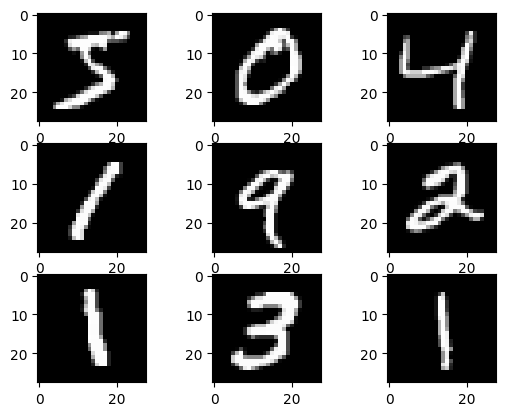

In [4]:
# Also, try to visualize individual images in this dataset by using imshow() function in pyplot.
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [5]:
# For preprocessing, scale the pixel values such that they lie between 0.0 and 1.0. 
# Make sure that you use the appropriate conversion to float wherever required while scaling.
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [6]:
def preprocess_data(train_X, train_Y, test_X, test_Y):
    # The data has images with 28 x 28 pixel values.
    # Since we use just one grayscale color channel, you need to reshape the matrix such that 
    # we have a 28 x 28 x 1 sized matrix holding each input data-point in the training and testing dataset.
    train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
    test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))
    print('Train: X=%s, y=%s' % (train_X.shape, train_Y.shape))
    print('Test: X=%s, y=%s' % (test_X.shape, test_Y.shape))

    # The output variable can be converted into a one-hot vector by using the function to_categorical 
    # (make sure you import to_categorical from keras.utils). 
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    train_X, test_X = prep_pixels(train_X, test_X)
    return train_X, train_Y, test_X, test_Y

Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


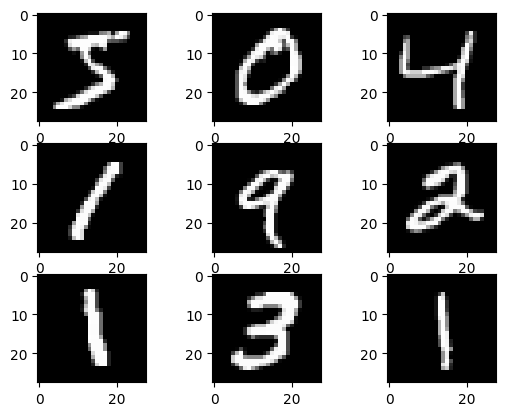

In [7]:
# Preprocess data
train_X, train_Y, test_X, test_Y = preprocess_data(train_X, train_Y, test_X, test_Y)

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [61]:
# Prepare the 10 distinct digits for the model explanations
inputs = []
seen = []
for i, y in enumerate(test_Y):
    if len(seen) == 10:
        break
    truth = np.argmax(y)
    if truth not in seen:
        inputs.append(test_X[i])
        seen.append(truth)

inputs = np.asarray(inputs)
inputs.shape

(10, 28, 28, 1)

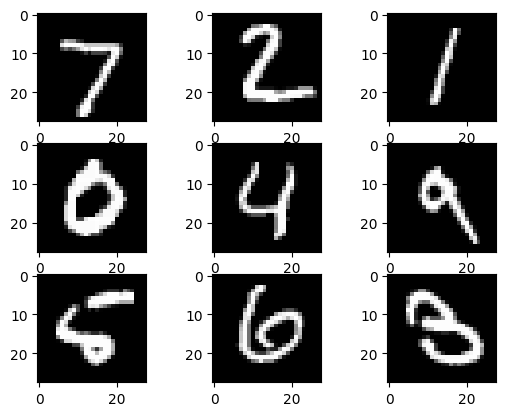

In [31]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(inputs[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [8]:
# Create a CNN model
def create_cnn():
    # define using Sequential
    model = Sequential()
    # Convolution layer
    model.add(
        Conv2D(32, (3, 3), 
               activation='relu', 
               kernel_initializer='he_uniform', 
               input_shape=(28, 28, 1))
    )
    # Maxpooling layer
    model.add(MaxPooling2D((2, 2)))
    # Add another convolution later, use 64 output filters
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # Flatten output
    model.add(Flatten())
    # Add dropout layer
    model.add(Dropout(0.5))
    # Dense layer of 100 neurons
    model.add(
        Dense(100, 
              activation='relu', 
              kernel_initializer='he_uniform')
    )
    model.add(Dense(10, activation='softmax'))
    # initialize optimizer
    opt = SGD(learning_rate=0.001, momentum=0.9)
    # compile model
    model.compile(
        optimizer=opt, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

model = create_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [9]:
# Fit model on training data
history = model.fit(
    train_X,
    train_Y,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10


2024-01-09 15:58:27.609323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-09 15:58:27.629232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


1688/1688 [==============================] - 19s 11ms/step - loss: 0.4216 - accuracy: 0.8695 - val_loss: 0.1174 - val_accuracy: 0.9677
Epoch 2/10
1688/1688 [==============================] - 18s 10ms/step - loss: 0.1596 - accuracy: 0.9519 - val_loss: 0.0827 - val_accuracy: 0.9778
Epoch 3/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1237 - accuracy: 0.9621 - val_loss: 0.0701 - val_accuracy: 0.9803
Epoch 4/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1070 - accuracy: 0.9676 - val_loss: 0.0661 - val_accuracy: 0.9815
Epoch 5/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0976 - accuracy: 0.9696 - val_loss: 0.0570 - val_accuracy: 0.9843
Epoch 6/10
1688/1688 [==============================] - 18s 11ms/step - loss: 0.0918 - accuracy: 0.9715 - val_loss: 0.0589 - val_accuracy: 0.9825
Epoch 7/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0888 - accuracy: 0.9721 - val_loss: 0.0581 - val_accura

In [10]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_X, test_Y, verbose=0)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [0.04896720126271248, 0.9844000339508057]


### SmoothGrad (SG)

SmoothGrad replaces the input with N identical versions of the input with added random noise. These noisy inputs are injected into the underlying attribution method and final attribution is the average attribution across N. This method samples the neighborhood of the input to approximate the gradient. It does not leverage the internals of the model, however, it needs access to the gradients. Thus, it can also be regarded as a gradient-based explanation method.

Gradient methods visualize the backpropagated error signal through the CNN $\frac{dy_k}{dx}$, the gradient of the input image $x$ with respect to a target class $y_k$. SmoothGrad enhances the common problem of noisy visualizations by averaging the gradient signal for an input with noise added to it. 

In [62]:
from tf_keras_vis.utils.scores import CategoricalScore

# 'seen' contains the 10 distinct digits
image_titles = [str(i) for i in seen]
score = CategoricalScore(seen)

In [63]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        inputs,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

CPU times: user 188 ms, sys: 110 ms, total: 299 ms
Wall time: 299 ms


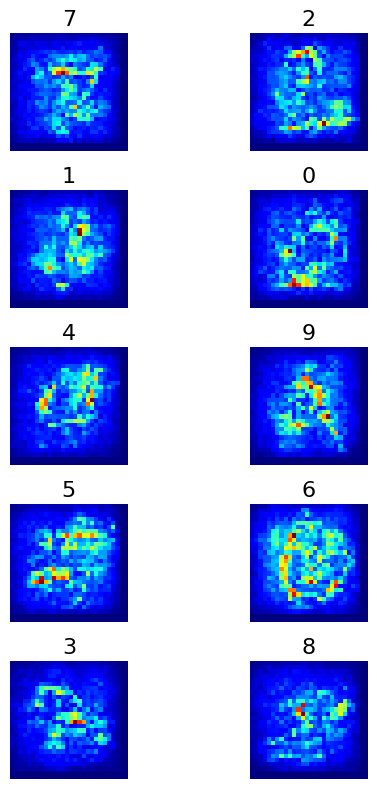

In [64]:
# Render
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 8))
for i, title in enumerate(image_titles):
    row = i // 2
    col = i % 2
    ax[row, col].set_title(title, fontsize=16)
    ax[row, col].imshow(saliency_map[i], cmap='jet')
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

### GRAD-CAM

In contrast to backprogation-based (gradient) visualizations, Class Activation Mapping (CAM) visualizes a CNN by linearly combining activation maps at the penultimate layer with the last layer's fully connected weights corresponding to a target class. Grad-CAM is a more flexible version of CAM as it is not limited to models with the penultimate layer being a global average pooling (GAP) layer. It weights the activation maps at a given layer by gradient backpropagation. 

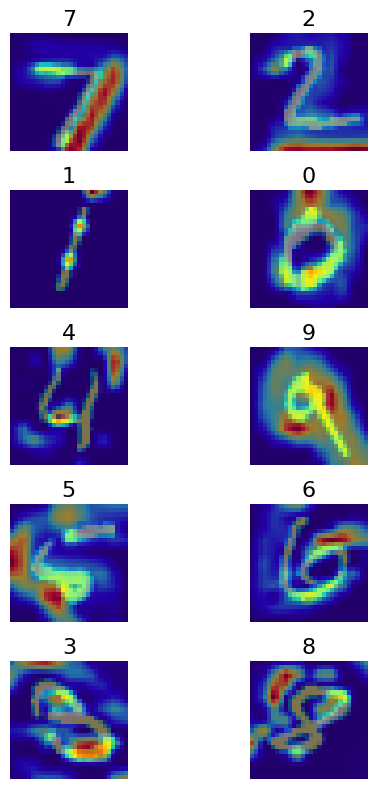

CPU times: user 460 ms, sys: 52.5 ms, total: 513 ms
Wall time: 670 ms


In [59]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create Gradcam object
gradcam = GradcamPlusPlus(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              inputs,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(6, 8))
for i, title in enumerate(image_titles):
    row = i // 2
    col = i % 2
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[row, col].set_title(title, fontsize=16)
    ax[row, col].imshow(inputs[i])
    ax[row, col].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[row, col].axis('off')
plt.tight_layout()
plt.show()

### SHAP Gradient Explainer
The Gradient SHAP explains a model using expected gradients (an extension of integrated gradients).

Integrated gradients attribute the predicted score to each input with respect to a baseline. This is achieved by constructing a set of inputs interpolating between the baseline and the input. It calculates an attribution value $a_{i}(x)$ for each input dimension $i$. The value $a_{i}(x)$ can be interpreted as the contribution of $i$ to changing the prediction from a baseline input $F(x′)$ to some specific input $F(x)$. It fulfills many useful properties, for example, it is guaranteed that $F(x)−F(x′) = \sum a_{i}(x)$. Thanks to the autodifferentiation frameworks like Tensorflow or PyTorch, Integrated Gradients can be easily obtained as it only depends on the function gradient.

Expected gradients an extension of the integrated gradients method (Sundararajan et al. 2017), a feature attribution method designed for differentiable models based on an extension of Shapley values to infinite player games (Aumann-Shapley values). Integrated gradients values are a bit different from SHAP values, and require a single reference value to integrate from. As an adaptation to make them approximate SHAP values, expected gradients reformulates the integral as an expectation and combines that expectation with sampling reference values from the background dataset. This leads to a single combined expectation of gradients that converges to attributions that sum to the difference between the expected model output and the current output. (From [documentation](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html#shap-gradientexplainer))

In [65]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, train_X)


In [66]:
# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values(inputs)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [67]:
# since the model has 10 outputs we get a list of 10 explanations (one for each output)
print(len(shap_values))

10


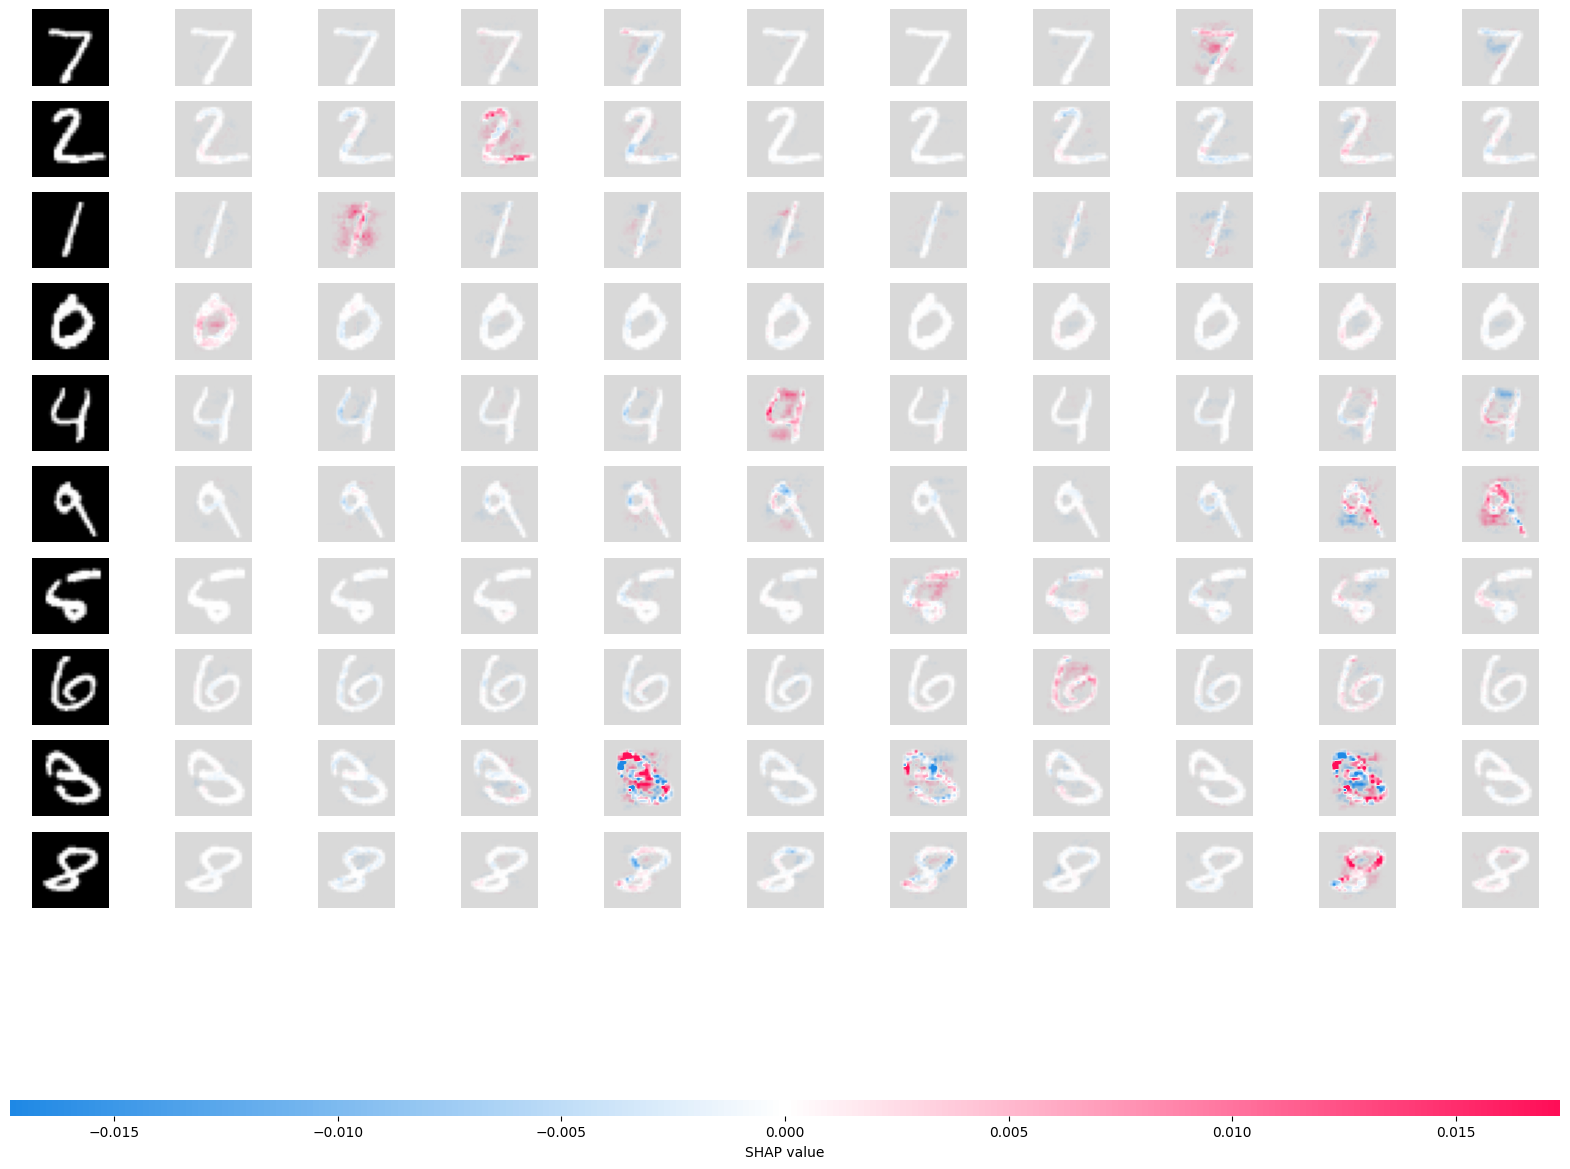

In [68]:
# here we plot the explanations for all classes
shap.image_plot([shap_values[i] for i in range(10)], inputs)

## Conclusion

The above examples (SmoothGrad, GRAD-CAM, Gradient SHAP) are some gradient-based methods which produce saliency maps to explain models for computer vision. The advantage of using these algorithms is that they are fast and easy to implement, as they can make use of the gradients of the existing architectures for efficient computation. However, these methods could be affected by noisy gradients, as shown in the outputs from SmoothGrad and Grad-CAM. Gradient SHAP produces a clearer model explanation with the blue area indicates negative attribution and red for the positives. We can observe from the plots of 4 and 9 the model differentiate the two characters by the top of the image - whether it is an open or closed circle. 